In [218]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import random
from IPython.display import display
from collections import defaultdict
from itertools import islice
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [219]:
def filter_data(df, cutoff):
    return df[df["Signal"] > cutoff]



def partition_data(df, diff):
    x = df[["RTime", "Source"]].to_numpy()
    dt  = np.diff(x[:, 0])
    pos = np.where(dt > diff)[0] + 1
    split = list(np.split(x, pos))

    res = []
    a = 1
    for cluster in split:
        for time, addr in cluster:
            res.append([time, a, addr])

        a += 1



    su = DataFrame(res, columns=["Time", "Cluster", "Source"])
    su = su.astype({"Time": np.float64, "Cluster": np.int32, "Source": str})
    return su



def filter_partitions(df, count):
    return df[df.groupby('Cluster')['Time'].transform('size') >= count]



def prep_partitions(df):
    means = df.groupby("Cluster")["Time"].mean().to_frame()
    means["nRequests"] = df.groupby("Cluster")["Time"].count()
    means["nDev"] = round(means["nRequests"] / 15).map(int)
    means["Time"] = means["Time"].map(int)
        
    return means[["Time", "nDev"]]


def driver(df, cutoff, diff, count):
    x = filter_data(df, cutoff)
    x = partition_data(x, diff)
    x = filter_partitions(x, count)
    x = prep_partitions(x)
    
    return x

In [220]:
def plot_network_graph(df, size=10, numClusters=5):
    G = nx.DiGraph()
    nodes = df.iloc[0:numClusters, :].to_numpy()
    
    for time, dev in nodes:
         G.add_node(time, nDev=dev)


    for start in nodes:
        for end in nodes:
            node_diff = end[0] - start[0]
            
            if node_diff <= 160 and node_diff >= 18:
                G.add_edge(start[0], end[0], val=node_diff)




    options = {
        "font_size": 12,
        "node_size": 1000,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 1,
        "width": 1,
        "with_labels": False
    }


    fig = plt.figure(1, figsize=(size, size))
    pos = graphviz_layout(G, prog='dot')
    nx.draw(G, pos, **options)


    devs = nx.get_node_attributes(G, 'nDev')
    node_labels = {}

    for k, v in devs.items():
        node_labels[k] = "{}\n{}".format(k, v)


    edge_labels = nx.get_edge_attributes(G,'val')
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    nx.draw_networkx_labels(G, pos, node_labels)
    plt.show()

In [221]:
# read in + a little bit of cleaning
df = pd.read_csv('../data/text/sample20.txt', sep='\t')
df = df.set_axis(["Time", "Channel", "Signal", "Source", "Dest", "Seq", "SSID", "BSSID"], axis=1)
df["RTime"] = df["Time"] - df["Time"][0]
df = df[["Time", "RTime", "Channel", "Signal", "Seq", "Source", "Dest", "SSID", "BSSID"]]
df = df.drop(["SSID", "BSSID"], axis=1)
df = df.replace("<MISSING>", np.NaN)


# map our channels
freq_map = {2412: 1, 2437: 6, 2462: 11}
df = df.replace({"Channel": freq_map})


display(df)

,Time,RTime,Channel,Signal,Seq,Source,Dest
0,1.667415e+09,0.000000,6,-93.0,1932.0,ee:b0:36:82:b5:bc,ff:ff:ff:ff:ff:ff
1,1.667415e+09,0.020600,6,-91.0,1933.0,ee:b0:36:82:b5:bc,ff:ff:ff:ff:ff:ff
2,1.667415e+09,0.077403,6,-89.0,1027.0,1e:9d:26:88:08:a1,ff:ff:ff:ff:ff:ff
3,1.667415e+09,0.101553,6,-93.0,1028.0,1e:9d:26:88:08:a1,ff:ff:ff:ff:ff:ff
4,1.667415e+09,0.178932,11,-87.0,2551.0,"2c:17:72:83:ec:a4,2c:17:72:83:ec:a4",NaN
...,...,...,...,...,...,...,...
93596,1.667419e+09,3762.706455,1,-97.0,152.0,a4:83:e7:62:09:23,ff:ff:ff:ff:ff:ff
93597,1.667419e+09,3762.746851,6,-68.0,3723.0,ce:0f:b4:ce:d4:93,ff:ff:ff:ff:ff:ff
93598,1.667419e+09,3762.768871,6,-65.0,3724.0,ce:0f:b4:ce:d4:93,ff:ff:ff:ff:ff:ff
93599,1.667419e+09,3762.799703,1,-88.0,2613.0,4a:75:3c:73:ae:e7,ff:ff:ff:ff:ff:ff


Let's get rid of any 96 bit MAC addresses.

In [222]:
# df = df[ df["Source"].str.len() < 20]
# df = df[ df["Dest"].str.len() < 20]

If we take a look at the probe requests that come in over 5 minutes, we can see that there appears to be a constant stream of them, which makes separating probe requests into buckets rather difficult:

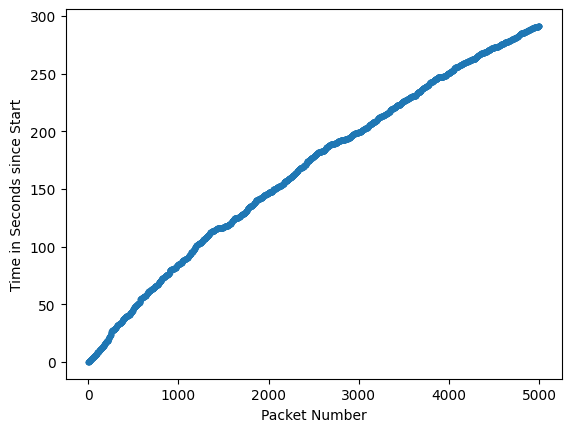

In [223]:
ax = df.iloc[0:5000]["RTime"].plot(style=".")
ax.set_ylabel("Time in Seconds since Start")
ax.set_xlabel("Packet Number")
plt.show()

Let's use our previous value of -45 and see what we come up with

In [224]:
filtered = filter_data(df, -42)
display(filtered)

,Time,RTime,Channel,Signal,Seq,Source,Dest
1432,1.667415e+09,115.675633,6,-33.0,1502.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1433,1.667415e+09,115.753851,6,-38.0,1507.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1434,1.667415e+09,115.755477,6,-36.0,1508.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1436,1.667415e+09,115.794135,6,-36.0,1510.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1437,1.667415e+09,115.795554,6,-37.0,1511.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
...,...,...,...,...,...,...,...
91692,1.667418e+09,3662.680313,6,-37.0,948.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91693,1.667418e+09,3662.681734,6,-39.0,949.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91695,1.667418e+09,3662.683328,6,-36.0,950.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91696,1.667418e+09,3662.718581,6,-39.0,951.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff


Only 420 entries! Let's see if theres any source MAC that shows up multiple times:

In [225]:
filtered.groupby("Source")["Time"].count()

Source
70:c1:9a:9b:b0:87      1
74:a8:85:54:7c:80      1
a3:10:c7:cb:b5:20      1
c7:26:2d:cc:28:16      1
d1:a1:16:87:62:41      1
e0:cd:8f:73:b0:20      1
e8:10:17:85:0c:b3      1
e8:10:eb:01:04:91      1
e8:50:8b:43:b1:20    411
fa:50:8b:43:60:95      1
Name: Time, dtype: int64

With a cutoff of -42, we can see that our target phone shows up 411 times while also have very little noise. We'll want to tweak this so we don't remove all of the other phones (since we're trying to capture it naturally). At this point, we can group together timestamps to form our clusters. We won't be using any fancy stats to separate them for now, and instead requests into clusters that are atleast 5 seconds away from the next probe.

In [226]:
su = partition_data(filtered, 5)
display(su)

,Time,Cluster,Source
0,115.675633,1,e8:50:8b:43:b1:20
1,115.753851,1,e8:50:8b:43:b1:20
2,115.755477,1,e8:50:8b:43:b1:20
3,115.794135,1,e8:50:8b:43:b1:20
4,115.795554,1,e8:50:8b:43:b1:20
...,...,...,...
415,3662.680313,28,e8:50:8b:43:b1:20
416,3662.681734,28,e8:50:8b:43:b1:20
417,3662.683328,28,e8:50:8b:43:b1:20
418,3662.718581,28,e8:50:8b:43:b1:20


In [227]:
su.groupby(["Cluster", "Source"]).count().head(10)

Time
Cluster Source                 
1       e8:50:8b:43:b1:20    11
2       d1:a1:16:87:62:41     1
        e8:50:8b:43:b1:20    14
        fa:50:8b:43:60:95     1
3       e8:50:8b:43:b1:20    14
4       e8:50:8b:43:b1:20    16
5       e8:50:8b:43:b1:20    15
6       e8:50:8b:43:b1:20    15
7       e8:50:8b:43:b1:20    16
8       e8:50:8b:43:b1:20    13

We can see that our samsung phone `(e8:50:8b:43:b1:20)` dominates most of these clusters and sends approximately 15 packets each scan. We'll use this value to determine how many devices are scanning at once. Now let's take a look at the time differences between clusters:

In [228]:
display(su.groupby("Cluster")["Time"].mean().diff())

Cluster
1            NaN
2     131.402620
3     131.372642
4     131.384366
5     131.370388
6     131.407102
7     131.365429
8     131.389767
9     131.387592
10    131.369921
11    131.369204
12    131.374956
13    131.387628
14    131.371534
15    131.396517
16    131.391468
17    131.370650
18    131.373426
19    131.377847
20    131.378606
21    131.384845
22    131.281726
23    131.291287
24    131.379164
25    131.270180
26    131.278180
27    131.273859
28    131.386928
Name: Time, dtype: float64

Interesting, we can see that scans are around 131 seconds apart. Naturally this is because we are only capturing the single device.

In [242]:
filtered = filter_data(df, -50)
display(filtered)

,Time,RTime,Channel,Signal,Seq,Source,Dest
1432,1.667415e+09,115.675633,6,-33.0,1502.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1433,1.667415e+09,115.753851,6,-38.0,1507.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1434,1.667415e+09,115.755477,6,-36.0,1508.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1436,1.667415e+09,115.794135,6,-36.0,1510.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1437,1.667415e+09,115.795554,6,-37.0,1511.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
...,...,...,...,...,...,...,...
91690,1.667418e+09,3662.639756,6,-36.0,947.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91692,1.667418e+09,3662.680313,6,-37.0,948.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91693,1.667418e+09,3662.681734,6,-39.0,949.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91695,1.667418e+09,3662.683328,6,-36.0,950.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff


In [243]:
filtered.groupby("Source")["Time"].count().sort_values(ascending=False)

Source
e8:50:8b:43:b1:20    347
70:c1:9a:9b:b0:87      1
74:a8:85:54:7c:80      1
e0:cd:8f:73:b0:20      1
e8:10:17:85:0c:b3      1
fa:50:8b:43:60:95      1
Name: Time, dtype: int64

It appears that there are only a few addresses that do not use MAC randomization.

In [244]:
x = filtered[["RTime", "Source"]].to_numpy()
su = partition_data(filtered, 5)
display(su)

,Time,Cluster,Source
0,115.675633,1,e8:50:8b:43:b1:20
1,115.753851,1,e8:50:8b:43:b1:20
2,115.755477,1,e8:50:8b:43:b1:20
3,115.794135,1,e8:50:8b:43:b1:20
4,115.795554,1,e8:50:8b:43:b1:20
...,...,...,...
347,3662.639756,28,e8:50:8b:43:b1:20
348,3662.680313,28,e8:50:8b:43:b1:20
349,3662.681734,28,e8:50:8b:43:b1:20
350,3662.683328,28,e8:50:8b:43:b1:20


We know that each cluster should have around 15 probe requests based on our earlier observations. Let's filter out any clusters with less than 10 requests.

In [245]:
su = filter_partitions(su, 10)
display(su)

,Time,Cluster,Source
9,247.134949,2,e8:50:8b:43:b1:20
10,247.136449,2,e8:50:8b:43:b1:20
11,247.137900,2,e8:50:8b:43:b1:20
12,247.176148,2,e8:50:8b:43:b1:20
13,247.177551,2,e8:50:8b:43:b1:20
...,...,...,...
347,3662.639756,28,e8:50:8b:43:b1:20
348,3662.680313,28,e8:50:8b:43:b1:20
349,3662.681734,28,e8:50:8b:43:b1:20
350,3662.683328,28,e8:50:8b:43:b1:20


Now let's see the mean values from each of these clusters:

In [246]:
means = prep_partitions(su)
display(means.sort_values(by="Time"))

,Time,nDev
Cluster,,
2,247,1
3,378,1
4,509,1
5,641,1
6,772,1
7,904,1
8,1035,1
9,1166,1
10,1298,1


And the differences between them:

In [247]:
diffs = means["Time"].diff()
display(diffs)

Cluster
2       NaN
3     131.0
4     131.0
5     132.0
6     131.0
7     132.0
8     131.0
9     131.0
10    132.0
11    131.0
12    132.0
13    131.0
14    131.0
15    132.0
16    131.0
17    131.0
18    132.0
19    131.0
20    132.0
21    131.0
22    131.0
23    132.0
25    262.0
26    131.0
27    132.0
28    131.0
Name: Time, dtype: float64

If we assume each phone sends around 15 requests, each cluster will have N / 15 devices transmitting at that time (where N is the number of requests in that cluster)

Now, let's create a graph where each node is identified by the time of the cluster. Nodes N1 and N2 have an edge between them if the time difference between them is under 160 seconds. 

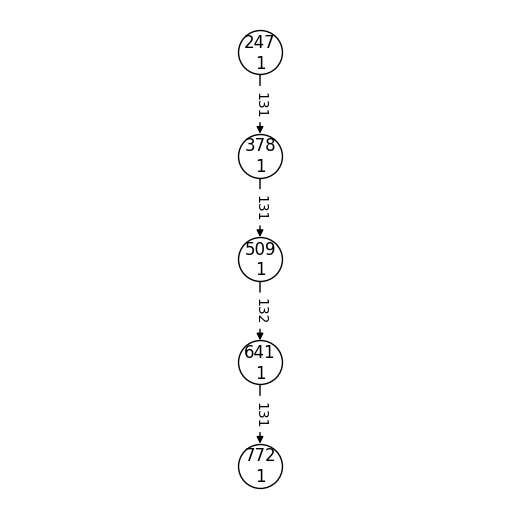

In [248]:
plot_network_graph(means, 5, 5)

Figuring out how many unique devices there are in this situation is rather simple. Each cluster has only 1 device transmitting in it (number on the bottom), and each cluster is a uniform distance away. This very likely to be our target device in the very last step of the scan plan, which means the time between scans is consistent and around 160 seconds. Now let's try introducing some more devices by reducing our signal strength filter. We'll limit the number of clusters we are looking at to reduce the visual cluster but the idea will be the same as in practice.

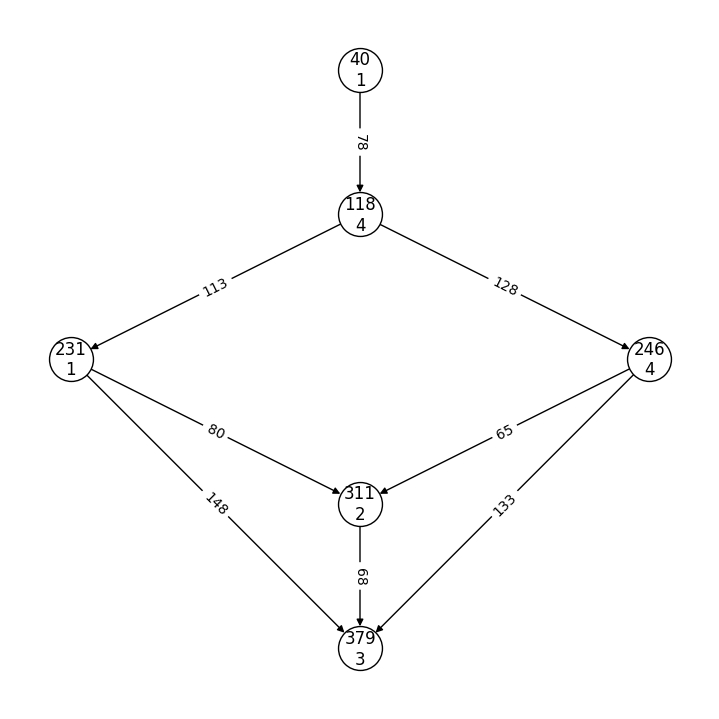

In [241]:
x = driver(df, -70, 5, 10)
plot_network_graph(x, 7, 6)

There are several things we must consider when trying to find the number of unique devices in a more complex graph. The first is that each device may be at a different point in the scan plan. If we only needed a rough estimate, we could assume that each device was in the last stage of the android scan plan. Including the other stages of the scan plan shouln't be too difficult. If we look at node 40, we can see that it is 78 seconds from the next node. This suggests that it is in stage 3 of the scan plan (80 seconds between scans), we should expect it to be around 160 seconds the next time. 